In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('../')

In [3]:
import sys
sys.path.append('/home/njr61/rds/hpc-work/spurious-concepts/ConceptBottleneck')

In [4]:
import torch
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
import torch.nn as nn
import torch.optim as optim
import pickle
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap
import cv2
from copy import copy 
import itertools

In [5]:
from ConceptBottleneck.CUB.models import ModelXtoC, ModelOracleCtoY
from ConceptBottleneck.CUB.dataset import load_data

In [6]:
from src.images import *
from src.util import *
from src.models import *
from src.plot import *

## Set up dataset + model

In [7]:
num_objects = 8

In [8]:
dataset_name = "synthetic_{}".format(num_objects)
data_dir = "../cem/cem/{}/preprocessed/".format(dataset_name)
num_attributes = 1
num_classes = 1

In [9]:
if num_objects == 2:
    concept_combinations = [
        [1,0,1,0],
        [0,1,0,1],
        [1,0,0,1],
        [0,1,1,0],
    ]
    concept_y = [
        0,1,1,1
    ]
else:
    concept_combinations = []
    concept_y = []
    for i in range(128):
        is_triangle = [random.randint(0,1) for j in range(num_objects)]
        is_square = [1-j for j in is_triangle]
        
        attribute_label = [elem for pair in zip(is_triangle, is_square) for elem in pair]
        concept_combinations.append(attribute_label)
        
        task_y = int(sum(is_square)<num_objects//2)
        concept_y.append(task_y)

In [10]:
train_data_path = os.path.join(data_dir, 'train.pkl')
val_data_path = train_data_path.replace('train.pkl', 'val.pkl')
extra_data_path = train_data_path.replace('train.pkl','extra.pkl')

In [11]:
pretrained = True
freeze = False
use_aux = True
expand_dim = 0
three_class = False
use_attr = True
no_img = False
batch_size = 64
uncertain_labels = False
image_dir = 'images'
num_class_attr = 2
resampling = False

In [12]:
train_loader = load_data([train_data_path], use_attr, no_img, batch_size, uncertain_labels, image_dir=image_dir, 
                         n_class_attr=num_class_attr, resampling=resampling, path_transform=lambda path: "../cem/cem/"+path, is_training=False)
val_loader = load_data([val_data_path], use_attr, no_img=False, batch_size=64, image_dir=image_dir, n_class_attr=num_class_attr, path_transform=lambda path: "../cem/cem/"+path)
extra_loader = load_data([extra_data_path], use_attr, no_img=False, batch_size=64, image_dir=image_dir, n_class_attr=num_class_attr, path_transform=lambda path: "../cem/cem/"+path)

In [13]:
joint_location = "ConceptBottleneck/results/{}/joint/best_model_42.pth".format(dataset_name)
joint_model = torch.load(joint_location,map_location=torch.device('cpu'))
r = joint_model.eval()

## Plot the Dataset

In [14]:
train_pkl = pickle.load(open(train_data_path,"rb"))
val_pkl = pickle.load(open(val_data_path,"rb"))
extra_pkl = pickle.load(open(extra_data_path,"rb"))

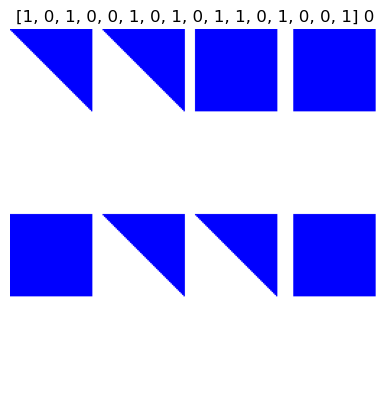

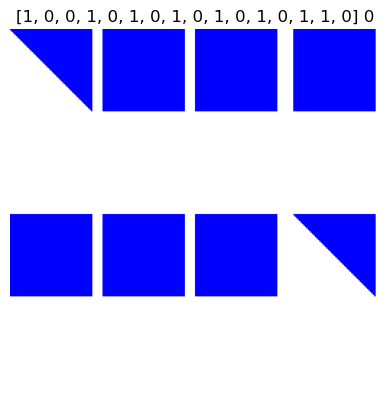

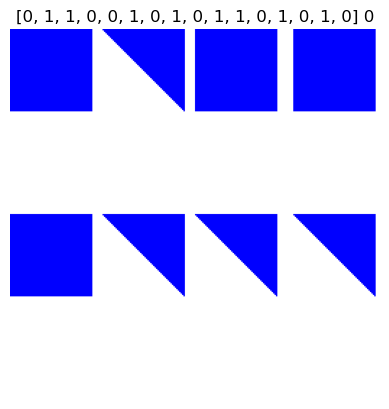

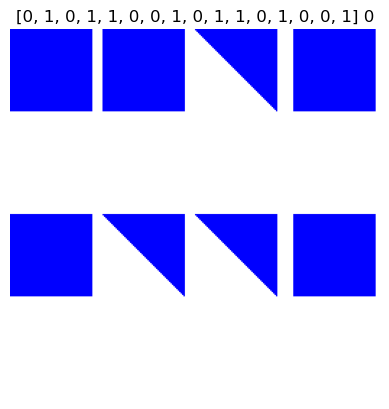

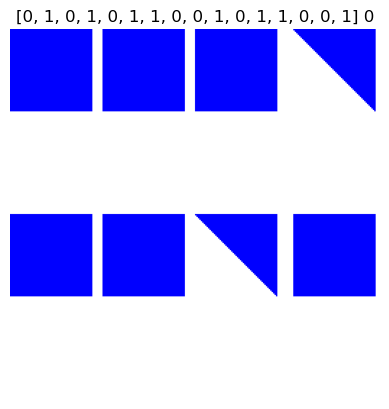

In [15]:
num_images_show = 5
for i in range(num_images_show):
    img_path = '../cem/cem/'+train_pkl[i]['img_path']
    image = Image.open(img_path)
    image_array = np.array(image)
    plt.figure()
    plt.imshow(image_array)
    plt.axis('off') 
    plt.title(str(train_pkl[i]['attribute_label']) + ' '+str(train_pkl[i]['class_label']))

## Analyze Accuracy

In [16]:
get_accuracy(joint_model,run_joint_model,train_loader), get_accuracy(joint_model,run_joint_model,val_loader)

(tensor(0.8408), tensor(0.8359))

In [17]:
get_concept_accuracy(joint_model,run_joint_model,train_loader,sigmoid=True)

(0.12055548001080751, 0.832763671875)

In [18]:
get_concept_accuracy_by_concept(joint_model,run_joint_model,train_loader,sigmoid=True)

tensor([0.8984, 0.8740, 0.9199, 0.9219, 0.8174, 0.8145, 0.6611, 0.7676, 0.8975,
        0.8047, 0.9717, 0.9678, 0.9736, 0.9658, 0.5342, 0.5342])

## Analyze Concept-Task Relationships

In [19]:
val_images = []
val_y = []
val_c = []
for batch in val_loader:
    x, y, c = batch  
    val_images.append(x)
    val_y.append(y)
    val_c.append(torch.stack(c).T)
val_images = torch.cat(val_images, dim=0)
val_y = torch.cat(val_y,dim=0)
val_c = torch.cat(val_c,dim=0)

In [20]:
extra_images = []
extra_y = []
extra_c = []
for batch in extra_loader:
    x,y,c = batch
    extra_images.append(x)
    extra_y.append(y)
    extra_c.append(torch.stack(c).T)
extra_images = torch.cat(extra_images, dim=0)
extra_y = torch.cat(extra_y,dim=0)
extra_c = torch.cat(extra_c,dim=0)

In [21]:
attribute_weights, y_pred, c_pred = get_attribute_class_weights(
    joint_model,run_joint_model,joint_model.sec_model.linear.weight,val_images)

In [22]:
attributes = [str(i) for i in range(num_objects*2)]

In [23]:
attribute_weights[:2,:,0]

tensor([[-0.0946, -0.2007, -0.4297, -0.6124, -0.4047, -1.0920,  0.2320,  0.3651,
         -0.1397, -0.3930, -5.2568, -3.3721,  2.0356,  6.6562,  2.0423,  1.6459],
        [ 0.0466,  0.2726,  0.7545,  0.2487,  0.4069,  0.5039, -0.1481, -0.2516,
          0.3387,  0.5818,  2.5866,  2.7339, -3.2950, -3.4400, -2.0501, -2.2306]],
       grad_fn=<SelectBackward0>)

[1.4547200202941895, 1.2375563383102417, 0.6869322657585144, 0.5913048386573792, 0.5151481628417969] ['14 (#14)', '15 (#15)', '5 (#5)', '13 (#13)', '3 (#3)']


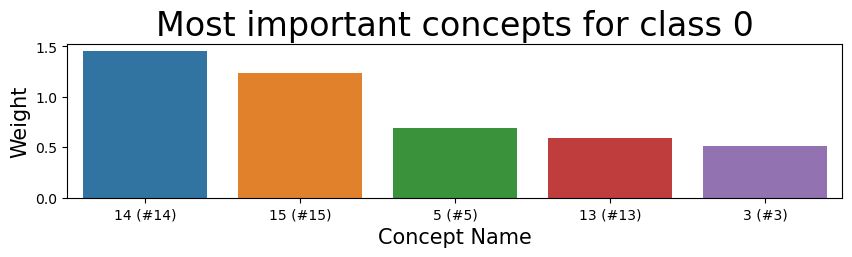

In [24]:
plt.figure(figsize=(10,2))
plt.title("Most important concepts for class 0",fontsize=24)
plt.xlabel("Concept Name",fontsize=15)
plt.ylabel("Weight",fontsize=15)
plot_most_important_classes(attribute_weights,attributes,0)

[0.7009503245353699, 0.5140341520309448, 0.3658265173435211, 0.31413254141807556, 0.30167457461357117] ['9 (#9)', '8 (#8)', '11 (#11)', '10 (#10)', '1 (#1)']


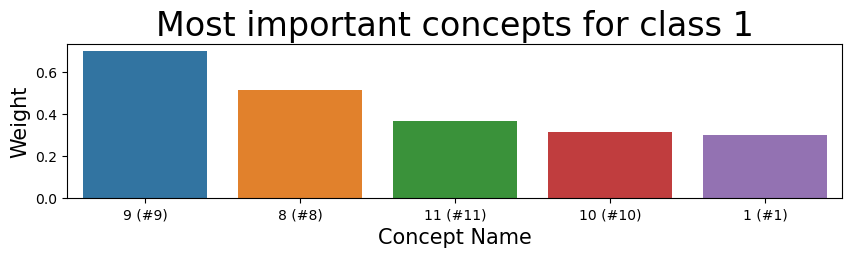

In [25]:
plt.figure(figsize=(10,2))
plt.title("Most important concepts for class 1",fontsize=24)
plt.xlabel("Concept Name",fontsize=15)
plt.ylabel("Weight",fontsize=15)
plot_most_important_classes(attribute_weights,attributes,1)

In [26]:
y_pred == joint_model.sec_model.forward(torch.nn.Sigmoid()(c_pred.T))

tensor([[True, True],
        [True, True],
        [True, True],
        ...,
        [True, True],
        [True, True],
        [True, True]])

### Impact of Each concept combination on task

In [27]:
for concept_combo, true_class in zip(concept_combinations,concept_y):
    predicted_result = joint_model.sec_model.forward(torch.Tensor([concept_combo]))
    predicted_class = torch.argmax(predicted_result[0])
    print("Predicted class {}, true class {}".format(predicted_class,true_class))

Predicted class 1, true class 1
Predicted class 1, true class 1
Predicted class 0, true class 0
Predicted class 1, true class 1
Predicted class 0, true class 0
Predicted class 0, true class 0
Predicted class 0, true class 0
Predicted class 1, true class 1
Predicted class 1, true class 1
Predicted class 0, true class 0
Predicted class 0, true class 0
Predicted class 0, true class 0
Predicted class 0, true class 0
Predicted class 0, true class 0
Predicted class 0, true class 0
Predicted class 0, true class 0
Predicted class 0, true class 0
Predicted class 1, true class 1
Predicted class 0, true class 0
Predicted class 1, true class 1
Predicted class 0, true class 0
Predicted class 0, true class 0
Predicted class 1, true class 1
Predicted class 1, true class 1
Predicted class 0, true class 0
Predicted class 0, true class 0
Predicted class 0, true class 0
Predicted class 0, true class 0
Predicted class 0, true class 0
Predicted class 0, true class 0
Predicted class 0, true class 0
Predicte

In [28]:
num_concepts = len(concept_combinations[0])
baseline_concepts = [0 for i in range(num_concepts)]

for i in range(num_concepts):
    new_concepts = copy(baseline_concepts)
    new_concepts[i] = 1
    predicted_result = joint_model.sec_model.forward(torch.Tensor([new_concepts]))
    predicted_class = torch.argmax(predicted_result[0])
    print("Predicted class {}, when setting concept {} to 1".format(predicted_class,i))

Predicted class 1, when setting concept 0 to 1
Predicted class 0, when setting concept 1 to 1
Predicted class 1, when setting concept 2 to 1
Predicted class 0, when setting concept 3 to 1
Predicted class 1, when setting concept 4 to 1
Predicted class 0, when setting concept 5 to 1
Predicted class 1, when setting concept 6 to 1
Predicted class 0, when setting concept 7 to 1
Predicted class 1, when setting concept 8 to 1
Predicted class 0, when setting concept 9 to 1
Predicted class 1, when setting concept 10 to 1
Predicted class 0, when setting concept 11 to 1
Predicted class 1, when setting concept 12 to 1
Predicted class 0, when setting concept 13 to 1
Predicted class 1, when setting concept 14 to 1
Predicted class 0, when setting concept 15 to 1


## Impact of Each Image on the Task

In [29]:
for i in range(num_concepts):
    avg_impact = np.array([0.0 for i in range(num_concepts)])
    num_combos = 0
    
    for concept_combo in concept_combinations:
        if concept_combo[i] != 0:
            continue

        closest_combo = None
        
        for other_combo in concept_combinations:
            if other_combo[i] != 1:
                continue

            if closest_combo == None:
                closest_combo = other_combo

            current_norm = np.linalg.norm(np.array(closest_combo)-np.array(concept_combo))
            this_norm = np.linalg.norm(np.array(other_combo)-np.array(concept_combo))
                
            if this_norm < current_norm:
                closest_combo = other_combo
                
        img_regular = [i for i in range(len(val_pkl)) if val_pkl[i]['attribute_label'] == concept_combo]
        img_regular = np.random.choice(img_regular)
        
        img_other = [i for i in range(len(val_pkl)) if val_pkl[i]['attribute_label'] == closest_combo]
        img_other = np.random.choice(img_other)
        
        y,c = run_joint_model(joint_model,val_images[img_regular:img_regular+1])
        y_other,c_other = run_joint_model(joint_model,val_images[img_other:img_other+1])
        
        c = torch.nn.Sigmoid()(c).detach().numpy().T[0]
        c_other = torch.nn.Sigmoid()(c_other).detach().numpy().T[0]
        
        num_combos += 1
        
        avg_impact += (c_other-c)
        
    avg_impact /= num_combos
    print("Concept {} Impact: {}".format(i,avg_impact))
        

ValueError: 'a' cannot be empty unless no samples are taken

In [ ]:
for i in range(len(extra_images)):
    concepts = extra_c[i]
    y,c = run_joint_model(joint_model,extra_images[i:i+1])
    c = c.T
    
    y = y.detach().numpy()
    c =  torch.nn.Sigmoid()(c).detach().numpy()
    concepts = concepts.detach().numpy()
    c = np.round(c,2)
    
    print("For concepts {}, predicted y {}, c {}".format(concepts,y[0],c[0]))

## Analyze Concept-Input Relationships

### Counterfactual Images

#### Blank, Filled, and Half Images

In [30]:
left_border = 21
right_border = 22
top_border = 21
bottom_border = 22

In [31]:
no_color = torch.Tensor([0.25,0.25,0.25])
full_color = torch.Tensor([-0.25,-0.25,0.25])
border_color = torch.Tensor([-0.25,-0.25,-0.25])

In [32]:
blank_image = no_color.clone().view(3, 1, 1).expand((3,256,256))
full_image = full_color.clone().view(3, 1, 1).expand_as(blank_image)

half_left = no_color.view(3, 1, 1).expand_as(blank_image).clone()
half_left[:,:,:128] = full_image[:,:,:128]

half_right = no_color.clone().view(3, 1, 1).expand_as(blank_image).clone()
half_right[:,:,128:] = full_image[:,:,128:]

In [33]:
all_images = [blank_image,full_image,half_left,half_right]
all_images = [image_with_borders(i,border_color,left_border,right_border,top_border,bottom_border)
             for i in all_images]
all_images = torch.stack(all_images)
str_names = ["Blank","Full","Half-Left","Half-Right"]

In [34]:
y,c = run_joint_model(joint_model,all_images)
c = c.T
c = torch.nn.Sigmoid()(c).detach().numpy()
c = np.round(c,3)

In [35]:
for i in range(len(str_names)):
    print("For image {}, concepts {}".format(str_names[i],c[i]))

For image Blank, concepts [0.507 0.5   0.419 0.565 0.444 0.557 0.491 0.482 0.499 0.514 0.46  0.552
 0.446 0.555 0.47  0.529]
For image Full, concepts [0.515 0.487 0.482 0.505 0.486 0.508 0.502 0.478 0.513 0.5   0.511 0.504
 0.509 0.479 0.492 0.507]
For image Half-Left, concepts [0.51  0.489 0.457 0.531 0.469 0.515 0.501 0.479 0.492 0.527 0.456 0.569
 0.496 0.506 0.481 0.521]
For image Half-Right, concepts [0.51  0.491 0.447 0.54  0.463 0.529 0.503 0.478 0.48  0.54  0.434 0.583
 0.527 0.483 0.472 0.526]


### Maximal Activation

In [36]:
ret_image = get_maximal_activation(joint_model,run_joint_model,0,valid_left_image)

In [37]:
torch.nn.Sigmoid()(run_joint_model(joint_model,ret_image)[1])

tensor([[1.0000e+00],
        [1.5092e-08],
        [7.1650e-04],
        [9.9973e-01],
        [1.9182e-06],
        [1.0000e+00],
        [2.4383e-03],
        [9.9847e-01],
        [9.6643e-01],
        [4.4578e-02],
        [1.1672e-01],
        [7.7027e-01],
        [2.7634e-01],
        [8.2228e-01],
        [2.8747e-03],
        [9.9789e-01]], grad_fn=<SigmoidBackward0>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


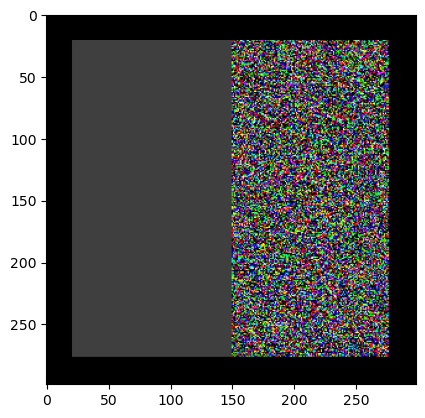

In [38]:
plt.imshow(ret_image.detach()[0].numpy().transpose((1,2,0)))

In [39]:
ret_image = get_maximal_activation(joint_model,run_joint_model,3,valid_right_image)

In [40]:
torch.nn.Sigmoid()(run_joint_model(joint_model,ret_image)[1])

tensor([[9.7187e-01],
        [7.0553e-03],
        [4.2494e-15],
        [1.0000e+00],
        [2.9981e-08],
        [1.0000e+00],
        [5.5539e-03],
        [9.9180e-01],
        [4.3748e-01],
        [6.2219e-01],
        [4.9225e-01],
        [4.6953e-01],
        [7.5327e-01],
        [2.5504e-01],
        [4.4574e-01],
        [4.6153e-01]], grad_fn=<SigmoidBackward0>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


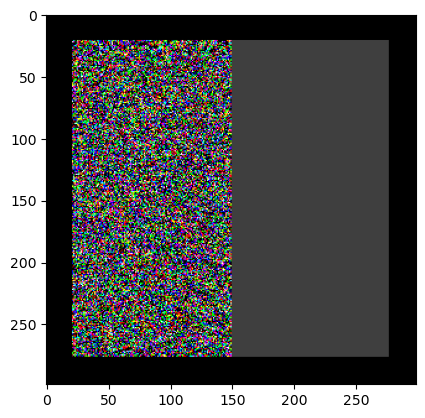

In [41]:
plt.imshow(ret_image.detach()[0].numpy().transpose((1,2,0)))

### Patch-Based

In [42]:
grid_size = 3
grid_width = 256//grid_size
combinations = list(itertools.product([0, 1], repeat=grid_size**2))
combinations_grid = [[list(combination[i:i+grid_size]) for i in range(0, grid_size**2, grid_size)] for combination in combinations]


In [43]:
def combo_to_image(combo):
    default_image = no_color.clone().view(3, 1, 1).expand((3,256,256)).clone()
    
    for i in range(grid_size):
        for j in range(grid_size):
            if combo[i][j] == 1:
                color_tensor = full_color.view(3, 1, 1).expand((3, grid_width, grid_width))
                default_image[:,i*grid_width:(i+1)*grid_width,j*grid_width:
                              (j+1)*grid_width] = color_tensor
                
                
    return image_with_borders(default_image,border_color,left_border,right_border,top_border,bottom_border)

In [44]:
all_images = torch.stack([combo_to_image(i) for i in combinations_grid])

In [45]:
y,c = run_joint_model(joint_model,all_images)
c = torch.nn.Sigmoid()(c)
c = c.T

In [46]:
def combination_to_string(combination):
    return ''.join(str(element) for row in combination for element in row)

In [47]:
combination_to_score = {}
for i,combination in enumerate(combinations_grid):
    condensed_string = combination_to_string(combination)
    combination_to_score[condensed_string] = c.detach().numpy()[i,0]

In [48]:
largest_indices = np.argsort(c.detach().numpy()[:,0])[-25:]

In [49]:
max_dif = 0
max_ind = -1

for i in largest_indices:
    combo_original = combinations_grid[i]
    modified_combo = deepcopy(combo_original)
    for j in range(grid_size):
        modified_combo[j][-1] = 0
        modified_combo[-1][j] = 0
        
    score_original = combination_to_score[combination_to_string(combo_original)]
    score_modified = combination_to_score[combination_to_string(modified_combo)]

    if score_original-score_modified > max_dif:
        max_dif = score_original-score_modified
        max_ind = i

In [50]:
combo_original = combinations_grid[max_ind]
modified_combo = deepcopy(combo_original)
for j in range(grid_size):
    modified_combo[j][-1] = 0
    modified_combo[-1][j] = 0
combination_to_score[combination_to_string(combo_original)], combination_to_score[combination_to_string(modified_combo)]

(0.5898419, 0.5016608)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


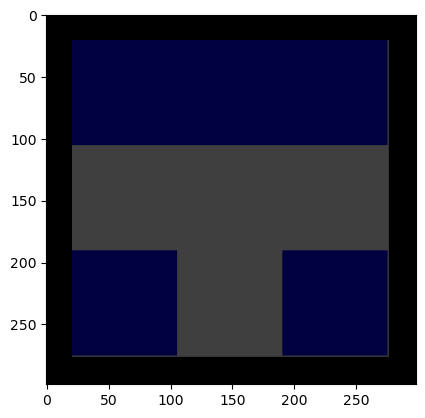

In [51]:
plt.imshow(combo_to_image(combo_original).detach().numpy().transpose((1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


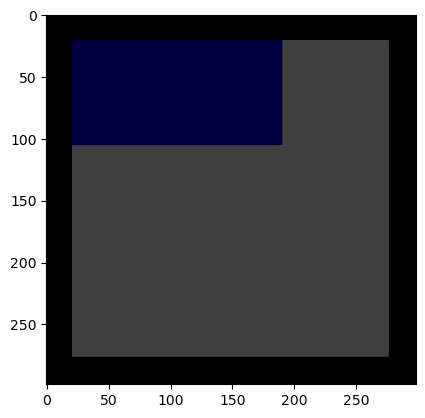

In [52]:
plt.imshow(combo_to_image(modified_combo).detach().numpy().transpose((1,2,0)))

### Saliency Maps

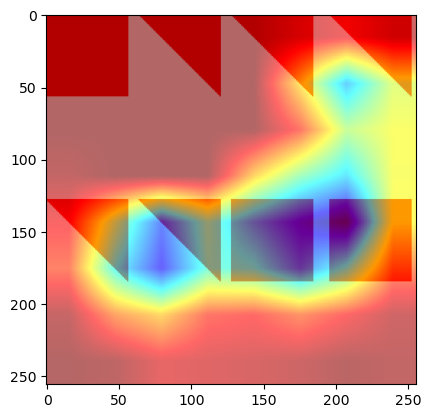

In [53]:
plot_gradcam(joint_model,run_joint_model,0,val_images,0,val_pkl)

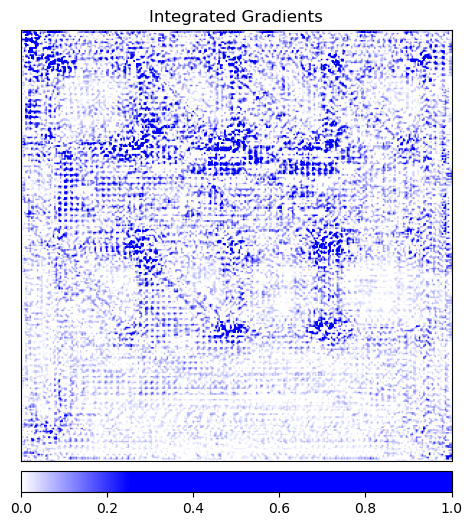

In [54]:
plot_integrated_gradients(joint_model,run_joint_model,0,val_images,0)

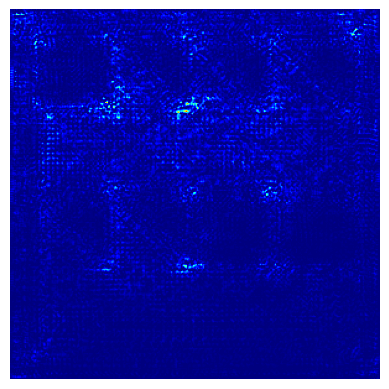

In [55]:
plot_saliency(joint_model,run_joint_model,0,val_images,0)

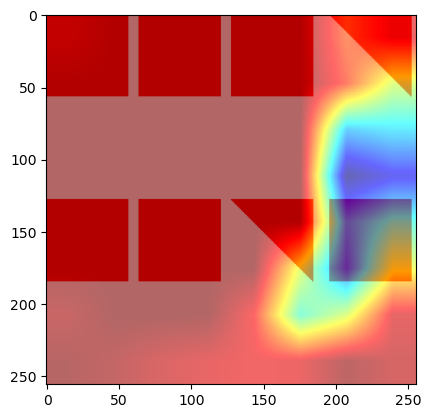

In [56]:
plot_gradcam(joint_model,run_joint_model,0,val_images,2,val_pkl)

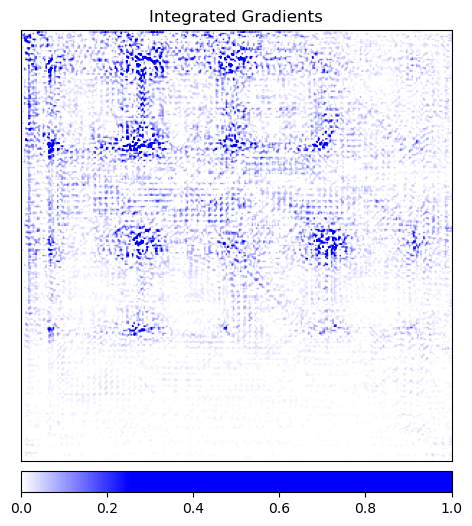

In [57]:
plot_integrated_gradients(joint_model,run_joint_model,0,val_images,2)

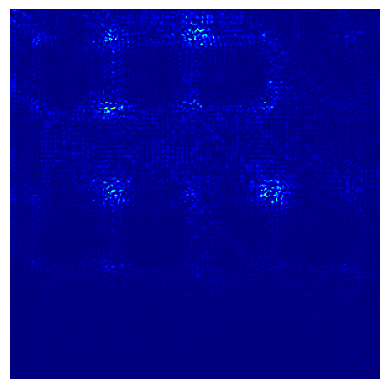

In [58]:
plot_saliency(joint_model,run_joint_model,0,val_images,2)

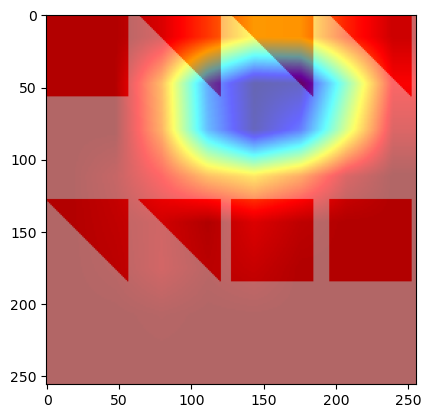

In [59]:
plot_gradcam(joint_model,run_joint_model,2,val_images,0,val_pkl)

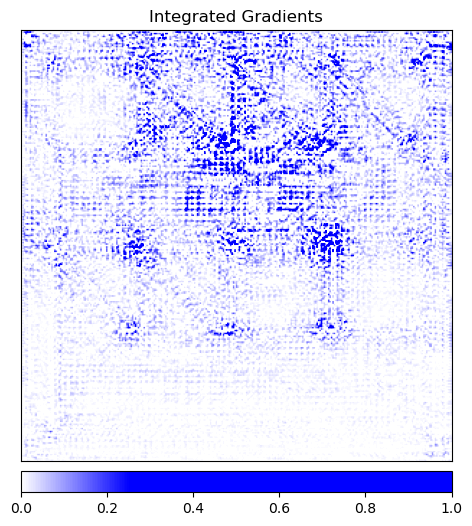

In [60]:
plot_integrated_gradients(joint_model,run_joint_model,2,val_images,0)

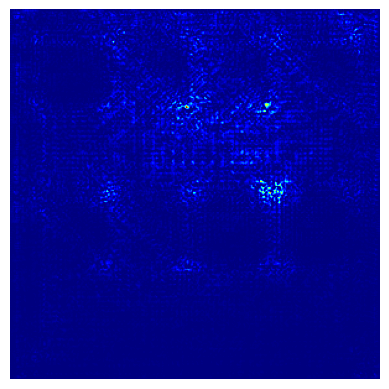

In [61]:
plot_saliency(joint_model,run_joint_model,2,val_images,0)